In [263]:
import numpy as np 
from numpy.linalg import norm
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from surprise import SVD,SVDpp,NMF,SlopeOne,KNNWithMeans
from surprise import Dataset,Reader,KNNBasic,accuracy,BaselineOnly , KNNWithZScore, KNNBaseline
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.model_selection import cross_validate
from IESEGRecSys import eval
from IESEGRecSys.model import ContentBased
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

# NLP packages
import nltk # pip install nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')

#fcluster we use to lable clusters and show them in plots
from scipy.cluster.hierarchy import linkage, fcluster
#vq we use to lable clusters and show them in plots
from scipy.cluster.vq import kmeans, vq


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malipourmotlagh1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malipourmotlagh1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration

In [2]:
artists = pd.read_table('./Data/Artists.dat', sep = '\t')
user_artists = pd.read_table('./Data/user_artists.dat', sep = '\t')
user_taggedartists = pd.read_table('./Data/user_taggedartists.dat', sep = '\t')
tags = pd.read_csv('./Data/tags.dat', sep = '\t', encoding='latin-1')

In [3]:
#head of the table
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [6]:
#head of the table
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [4]:
#head of the table
user_taggedartists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [5]:
#head of the table
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [9]:
print(artists['name'].nunique(),\
user_artists['artistID'].nunique(),\
user_taggedartists['artistID'].nunique())
print(user_artists['userID'].nunique(),\
user_taggedartists['userID'].nunique())

17632 17632 12523
1892 1892


based on the above we can see that the number of unique artists in diferent tables are diferent then here we will merge data for exploration using user_taggedartists table as first table for left join and in the model evaluation we will filter data

In [100]:
BaseTable=user_taggedartists.merge(user_artists,on=['artistID','userID'],how='right')
BaseTable=BaseTable.merge(artists,left_on='artistID',right_on='id',how='left')
BaseTable=BaseTable.merge(tags,on='tagID',how='left')
BaseTable.drop(['id','url','pictureURL'],axis=1,inplace=True)
BaseTable.head()

,userID,artistID,tagID,day,month,year,weight,name,tagValue
0,2,51,NaN,NaN,NaN,NaN,13883,Duran Duran,NaN
1,2,52,13.0,1.0,4.0,2009.0,11690,Morcheeba,chillout
2,2,52,15.0,1.0,4.0,2009.0,11690,Morcheeba,downtempo
3,2,52,18.0,1.0,4.0,2009.0,11690,Morcheeba,electronic
4,2,52,21.0,1.0,4.0,2009.0,11690,Morcheeba,trip-hop


In [102]:
#creating 2 column by 10 and 5 rating base
# Create the variable ratings_10 based on the weight percentage localization
BaseTable['ratings_10']=10
BaseTable.loc[BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.1),'ratings_10']=1
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.1))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.2)),'ratings_10']=2
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.2))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.3)),'ratings_10']=3
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.3))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.4)),'ratings_10']=4
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.4))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.5)),'ratings_10']=5
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.5))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.6)),'ratings_10']=6
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.6))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.7)),'ratings_10']=7
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.7))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.8)),'ratings_10']=8
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.8))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.9)),'ratings_10']=9
# Create the variable ratings_5 based on the weight percentage localization
BaseTable['ratings_5']=5
BaseTable.loc[BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.2),'ratings_5']=1
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.2))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.4)),'ratings_5']=2
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.4))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.6)),'ratings_5']=3
BaseTable.loc[(BaseTable['weight']>np.quantile(BaseTable['weight'], 0.6))\
                &(BaseTable['weight']<=np.quantile(BaseTable['weight'], 0.8)),'ratings_5']=4

BaseTable.head()

,userID,artistID,tagID,day,month,year,weight,name,tagValue,ratings_10,ratings_5
0,2,51,NaN,NaN,NaN,NaN,13883,Duran Duran,NaN,10,5
1,2,52,13.0,1.0,4.0,2009.0,11690,Morcheeba,chillout,10,5
2,2,52,15.0,1.0,4.0,2009.0,11690,Morcheeba,downtempo,10,5
3,2,52,18.0,1.0,4.0,2009.0,11690,Morcheeba,electronic,10,5
4,2,52,21.0,1.0,4.0,2009.0,11690,Morcheeba,trip-hop,10,5


In [167]:
BaseTable.groupby('year',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})

,year,userID,artistID,tagID,weight,ratings_10,ratings_5
0,1956.0,1,1,1,548.000000,7.000000,4.000000
1,1957.0,1,1,1,399.000000,6.000000,3.000000
2,2005.0,33,275,184,1365.755344,5.757720,3.122328
3,2006.0,162,841,730,2195.362381,7.271249,3.870819
4,2007.0,372,1575,1355,2160.026963,6.647634,3.553661
5,2008.0,675,2600,2553,2233.200041,6.736199,3.605351
6,2009.0,829,2858,2710,2480.068465,6.524858,3.497218
7,2010.0,915,3214,3492,2292.354098,5.962926,3.207987
8,2011.0,453,1283,1357,1799.498795,5.273124,2.879331


we can see that there is a few data in 1956 1957 that is not relevant and we can drop them 

In [168]:
BaseTable[BaseTable['year']==1956]

,userID,artistID,tagID,day,month,year,weight,name,tagValue,ratings_10,ratings_5
3260,43,1395,39.0,1.0,6.0,1956.0,548,Freemasons,dance,7,4


In [175]:
BaseTable[BaseTable['userID']==43]

,userID,artistID,tagID,day,month,year,weight,name,tagValue,ratings_10,ratings_5
3194,43,53,NaN,NaN,NaN,NaN,289,Air,NaN,5,3
3195,43,56,NaN,NaN,NaN,NaN,2691,Daft Punk,NaN,10,5
3196,43,58,NaN,NaN,NaN,NaN,162,Goldfrapp,NaN,3,2
3197,43,64,13.0,1.0,11.0,2010.0,6390,Röyksopp,chillout,10,5
3198,43,64,15.0,1.0,9.0,2010.0,6390,Röyksopp,downtempo,10,5
...,...,...,...,...,...,...,...,...,...,...,...
3283,43,1409,203.0,1.0,5.0,2010.0,123,Calvin Harris,disco,3,2
3284,43,1409,309.0,1.0,5.0,2010.0,123,Calvin Harris,electro,3,2
3285,43,1410,187.0,1.0,7.0,2010.0,120,Pendulum,electronica,3,2
3286,43,1410,624.0,1.0,7.0,2010.0,120,Pendulum,electro house,3,2


In [169]:
BaseTable[BaseTable['year']==1957]

,userID,artistID,tagID,day,month,year,weight,name,tagValue,ratings_10,ratings_5
10195,133,2984,1474.0,1.0,3.0,1957.0,399,Claudia Leitte,axe,6,3


In [176]:
BaseTable[BaseTable['userID']==133]

,userID,artistID,tagID,day,month,year,weight,name,tagValue,ratings_10,ratings_5
10136,133,67,24.0,5.0,5.0,2011.0,839,Madonna,pop,8,4
10137,133,67,25.0,1.0,2.0,2011.0,839,Madonna,80s,8,4
10138,133,67,512.0,1.0,3.0,2011.0,839,Madonna,romantic,8,4
10139,133,89,24.0,1.0,4.0,2010.0,189,Lady Gaga,pop,4,2
10140,133,157,24.0,1.0,7.0,2010.0,317,Michael Jackson,pop,5,3
...,...,...,...,...,...,...,...,...,...,...,...
10195,133,2984,1474.0,1.0,3.0,1957.0,399,Claudia Leitte,axe,6,3
10196,133,3172,NaN,NaN,NaN,NaN,154,Claudia Leitte - As Máscaras - 2O1O,NaN,3,2
10197,133,3173,NaN,NaN,NaN,NaN,132,Ivete Sangalo,NaN,3,2
10198,133,3174,1475.0,1.0,1.0,2011.0,105,Banda Da Loirinha,forro,3,2


Based on above tables we can see that user numbers 133 and 43 are active in different years then we just decide to ingore that two year, most probably this two years are entry mistakes and will have no results in the final predictions

In [139]:
# agragating data for month and crating a long table for each year
#year 2005
B_5=BaseTable[BaseTable['year']==2005].groupby('month',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})
B_5['year']=2005
B_5['month']=B_5['month'].astype(int)
#year 2006
B_6=BaseTable[BaseTable['year']==2006].groupby('month',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})
B_6['year']=2006
B_6['month']=B_6['month'].astype(int)
#year 2007
B_7=BaseTable[BaseTable['year']==2007].groupby('month',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})
B_7['year']=2007
B_7['month']=B_7['month'].astype(int)
#year 2008
B_8=BaseTable[BaseTable['year']==2008].groupby('month',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})
B_8['year']=2008
B_8['month']=B_8['month'].astype(int)
#year 2009
B_9=BaseTable[BaseTable['year']==2009].groupby('month',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})
B_9['year']=2009
B_9['month']=B_9['month'].astype(int)
#year 2010
B_10=BaseTable[BaseTable['year']==2010].groupby('month',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})
B_10['year']=2010
B_10['month']=B_10['month'].astype(int)
#year 2011
B_11=BaseTable[BaseTable['year']==2011].groupby('month',as_index=False)\
    .agg({'userID':'nunique','artistID':'nunique','tagID':'nunique','weight':'mean','ratings_10':'mean','ratings_5':'mean'})
B_11['year']=2011
B_11['month']=B_11['month'].astype(int)
#concatenating all tables together
BLong=B_11.append(B_10.append(B_9.append(B_8.append(B_8.append(B_8.append(B_7))))))
#new column
BLong['Date']=BLong['year'].astype(str)+'-'+BLong['month'].astype(str)
BLong=BLong.reset_index(drop=True)
BLong=BLong.sort_index(ascending=False)
#showing the data
BLong.head()



,month,userID,artistID,tagID,weight,ratings_10,ratings_5,year,Date
75,12,110,319,360,1946.085239,6.603950,3.534304,2007,2007-12
74,11,101,353,306,1712.260638,6.926596,3.712766,2007,2007-11
73,10,89,328,300,3398.226341,6.587317,3.530732,2007,2007-10
72,9,81,241,284,2208.008403,7.361345,3.903361,2007,2007-9
71,8,85,237,238,1367.886525,5.932624,3.187943,2007,2007-8


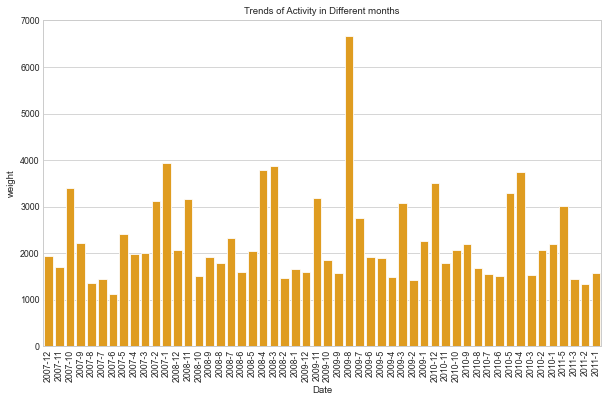

In [343]:
#Trends of Activity in Different months
with plt.style.context('seaborn-whitegrid'):
    fig, axes = plt.subplots( figsize=(10, 6), sharey=True)
    sns.barplot(data=BLong,x='Date',y='weight',color='orange')
    plt.title('Trends of Activity in Different months')
    plt.xticks(rotation = 90)
    fig.savefig('./figs/Trends of Activity in Different months.jpg')

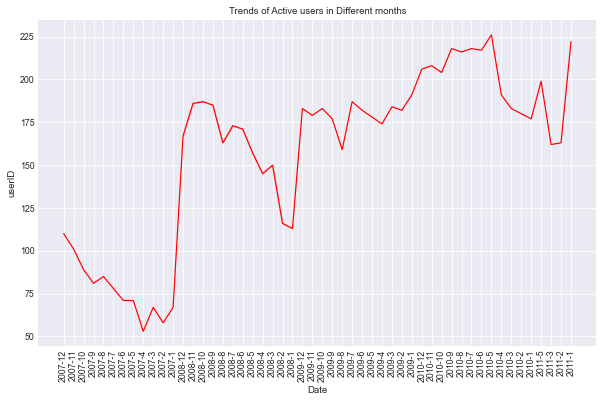

In [342]:
#Trends of Active users in Different months
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 6), sharey=True)
    sns.lineplot(data=BLong,x='Date',y='userID',color='red')
    plt.title('Trends of Active users in Different months')
    plt.xticks(rotation = 90)
    fig.savefig('./figs/Trends of Active users in Different months.jpg')

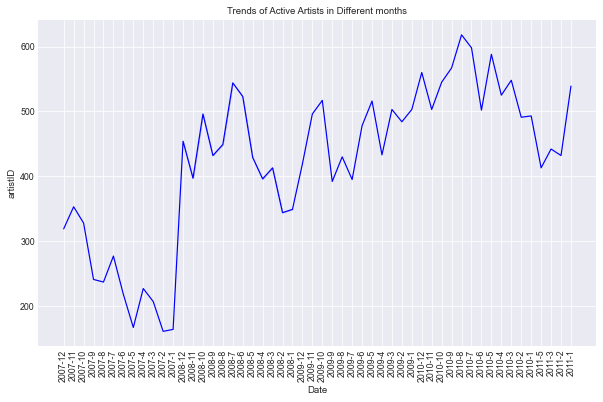

In [344]:
#Trends of Active Artists in Different months
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 6), sharey=True)
    sns.set_style("darkgrid")
    sns.lineplot(data=BLong,x='Date',y='artistID',color='blue')
    plt.title('Trends of Active Artists in Different months')
    plt.xticks(rotation = 90)
    fig.savefig('./figs/Trends of Active Artists in Different months.jpg')

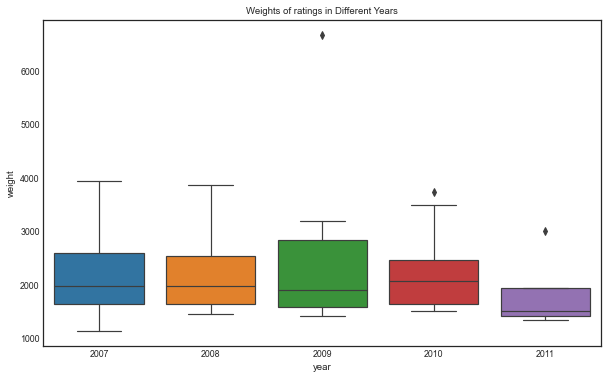

In [345]:
#Weights of ratings in Different Years
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots( figsize=(10, 6), sharey=True)
    sns.boxplot(data=BLong,y='weight',x='year')
    plt.title('Weights of ratings in Different Years')
    #plt.xticks(rotation = 90)
    fig.savefig('./figs/Weights of ratings in Different Years.jpg')

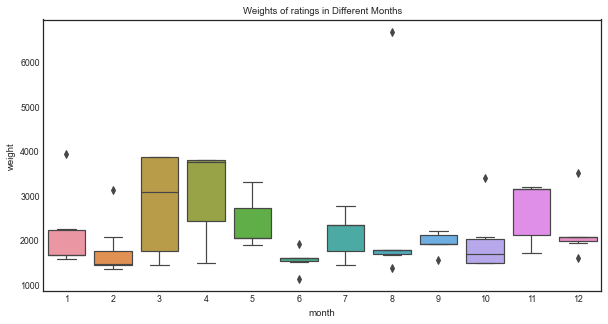

In [346]:
#Weights of ratings in Different Months
with plt.style.context('seaborn-white'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    sns.boxplot(data=BLong,y='weight',x='month')
    plt.title('Weights of ratings in Different Months')
    #plt.xticks(rotation = 90)
    fig.savefig('./figs/Weights of ratings in Different Months.jpg')

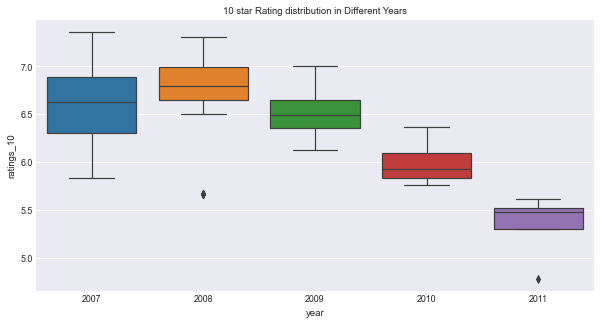

In [347]:
#10 star Rating distribution in Different years
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    sns.boxplot(data=BLong,y='ratings_10',x='year')
    plt.title('10 star Rating distribution in Different Years')
    #plt.xticks(rotation = 90)
    fig.savefig('./figs/10 star Rating distribution in Different Years.jpg')

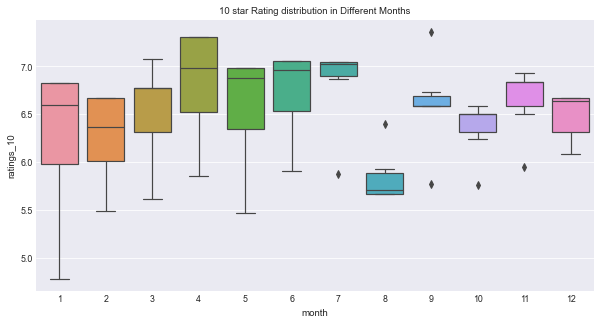

In [348]:
#10 star Rating distribution in Different Months
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    sns.boxplot(data=BLong,y='ratings_10',x='month')
    plt.title('10 star Rating distribution in Different Months')
    #plt.xticks(rotation = 90)
    fig.savefig('./figs/10 star Rating distribution in Different Months.jpg')

In [117]:
A_5=BaseTable[BaseTable['year']==2005].groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
A_5['year']=2005
A_6=BaseTable[BaseTable['year']==2006].groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
A_6['year']=2006
A_7=BaseTable[BaseTable['year']==2007].groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
A_7['year']=2007
A_8=BaseTable[BaseTable['year']==2008].groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
A_8['year']=2008
A_9=BaseTable[BaseTable['year']==2009].groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
A_9['year']=2009
A_10=BaseTable[BaseTable['year']==2010].groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
A_10['year']=2010
A_11=BaseTable[BaseTable['year']==2011].groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
A_11['year']=2011

ALong=A_11.append(A_10.append(A_9.append(A_8.append(A_8.append(A_8.append(A_7))))))
ALong.head()

,artistID,name,weight,ratings_10,ratings_5,year
260,792,Thalía,324663.000,10.000000,5.0,2011
913,6373,Tyler Adam,30614.000,10.000000,5.0,2011
620,2548,Wanessa,23558.375,10.000000,5.0,2011
357,1081,Ace of Base,21711.000,10.000000,5.0,2011
221,679,Glee Cast,20744.000,5.333333,3.0,2011


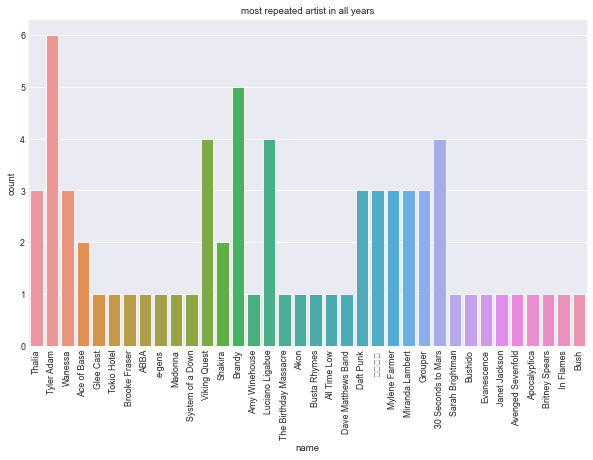

In [350]:
# most repeated artist in all years
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 6), sharey=True)
    sns.countplot(data=ALong,x='name')
    plt.title('most repeated artist in all years')
    plt.xticks(rotation = 90)
    fig.savefig('./figs/most repeated artist in all years.jpg')


In [116]:
all_year_top=BaseTable.groupby(['artistID','name'],as_index=False)\
    .agg({'weight':'mean','ratings_10':'mean','ratings_5':'mean'}).sort_values(by='weight',ascending=False).head(10)
all_year_top

,artistID,name,weight,ratings_10,ratings_5
783,792,Thalía,123512.012987,7.922078,4.103896
8195,8388,Viking Quest,35323.000000,10.000000,5.000000
6241,6373,Tyler Adam,30614.000000,10.000000,5.000000
17093,18121,Rytmus,23462.000000,10.000000,5.000000
695,701,Shakira,21800.760536,6.703065,3.553640
3464,3501,Mylène Farmer,19887.456522,8.521739,4.445652
2029,2044,Sarah Brightman,16599.592593,8.814815,4.546296
8115,8308,Johnny Hallyday,16497.500000,5.500000,3.000000
13599,14185,Brooke Fraser,15691.187500,9.812500,4.937500
14282,14986,Dicky Dixon,15345.000000,10.000000,5.000000


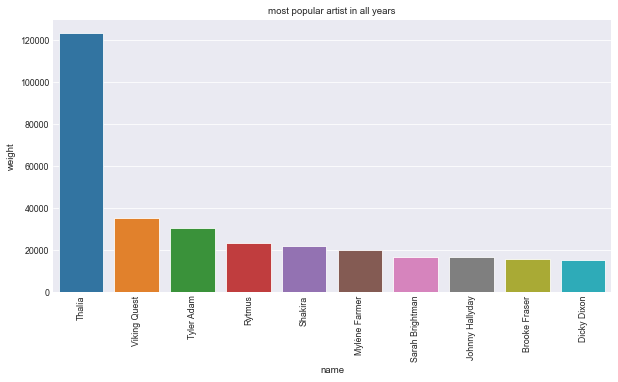

In [351]:
# most popular artist in all years
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    sns.barplot(data=all_year_top.sort_values(by='weight',ascending=False),x='name',y='weight')
    plt.title('most popular artist in all years')
    plt.xticks(rotation = 90)
    fig.savefig('./figs/most popular artist in all years.jpg')

## Colaborative Recomendation System

In [144]:
# Data cleaning based on the match between the datasets user_artist and user_taggedartists
user_artists=user_artists[user_artists['artistID'].isin(user_taggedartists['artistID'])]

In [145]:
# Create the variable ratings_10 based on the weight percentage localization

user_artists['ratings_10']=10
user_artists.loc[user_artists['weight']<=np.quantile(user_artists['weight'], 0.1),'ratings_10']=1
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.1))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.2)),'ratings_10']=2
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.2))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.3)),'ratings_10']=3
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.3))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.4)),'ratings_10']=4
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.4))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.5)),'ratings_10']=5
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.5))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.6)),'ratings_10']=6
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.6))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.7)),'ratings_10']=7
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.7))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.8)),'ratings_10']=8
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.8))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.9)),'ratings_10']=9
                

In [146]:
# Create the variable ratings_5 based on the weight percentage localization

user_artists['ratings_5']=5
user_artists.loc[user_artists['weight']<=np.quantile(user_artists['weight'], 0.2),'ratings_5']=1
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.2))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.4)),'ratings_5']=2
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.4))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.6)),'ratings_5']=3
user_artists.loc[(user_artists['weight']>np.quantile(user_artists['weight'], 0.6))\
                &(user_artists['weight']<=np.quantile(user_artists['weight'], 0.8)),'ratings_5']=4


In [147]:
# Check some dataset  details for the new column ratings_10
user_artists.groupby('ratings_10',as_index=False).agg({'userID':['nunique','count'],'artistID':['nunique','count'],'weight':'mean'})

ratings_10  userID       artistID             weight
             nunique count  nunique count         mean
0          1     419  8786     4037  8786    18.922832
1          2     720  8566     3608  8566    64.774340
2          3     954  8673     3600  8673   113.231177
3          4    1170  8746     3566  8746   166.980334
4          5    1307  8621     3378  8621   232.975641
5          6    1398  8592     3383  8592   319.406774
6          7    1429  8670     3327  8670   443.684544
7          8    1439  8637     3124  8637   645.326850
8          9    1388  8661     2935  8661  1062.651310
9         10    1272  8656     2513  8656  4698.030961

In [148]:
# Check some dataset details for the new column ratings_5
user_artists.groupby('ratings_5',as_index=False).agg({'userID':['nunique','count'],'artistID':['nunique','count'],'weight':'mean'})

ratings_5  userID        artistID              weight
            nunique  count  nunique  count         mean
0         1     785  17352     5938  17352    41.557918
1         2    1228  17419     5483  17419   140.218382
2         3    1492  17213     5156  17213   276.118399
3         4    1573  17307     4907  17307   544.313457
4         5    1506  17317     4074  17317  2879.816308

In [152]:
# Create the data frame from the userID, artistID and ratings_10 variables from user_artist data table
data=pd.DataFrame()
data['userID']=user_artists['userID']
data['artistID']=user_artists['artistID']
data['ratings']=user_artists['ratings_10']

# Reader rating scale setup 1 for lowest and 10 for highest
datas = Reader(rating_scale=(1, 10))
data_sup=Dataset.load_from_df(data,datas)

### Ratings 1-10

 Run 5-fold cross-validation and print results for NMF(), SlopeOne(), SVDpp(), SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly() and CoClustering().

Code Reference: https://gist.github.com/susanli2016/e0cdcf1bca69a2b144fd8c04f30b522f


In [153]:
benchmark = []

# Iterate over all algorithms

algorithms = [NMF(), SlopeOne(), SVDpp(), SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    results2 = cross_validate(algorithm, data_sup, measures=['RMSE', 'MAE'], cv=5, verbose=False)  # Perform cross validation    
    tmp = pd.DataFrame.from_dict(results2).mean(axis=0) # Get results & append algorithm name
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000252BAD45430>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x00000252BAD45FA0>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x00000252BAD453A0>, <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000252BAD455E0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x00000252BAD45F70>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x00000252BAD457F0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000252BAD45D60>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x00000252BAC04040>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x00000252BAD4F370>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x00000252BAD4F1F0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000252BAD45430>
Done:  <surprise.prediction_algorith

In [228]:
# Display the results
surprise_results_1to10 = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results_1to10


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,1.735013,1.360255,3.966493,0.117298
SVDpp,1.776446,1.349833,44.205032,0.938612
BaselineOnly,1.821113,1.509361,0.298791,0.082272
KNNBaseline,1.856756,1.470482,0.848849,1.932171
SlopeOne,1.910280,1.455238,3.690437,0.597051
KNNWithMeans,1.910701,1.462006,0.547887,1.741116
KNNWithZScore,1.912240,1.446648,0.651515,1.874884
CoClustering,1.983899,1.527714,3.130970,0.099995
NMF,2.169259,1.649416,6.368566,0.122042


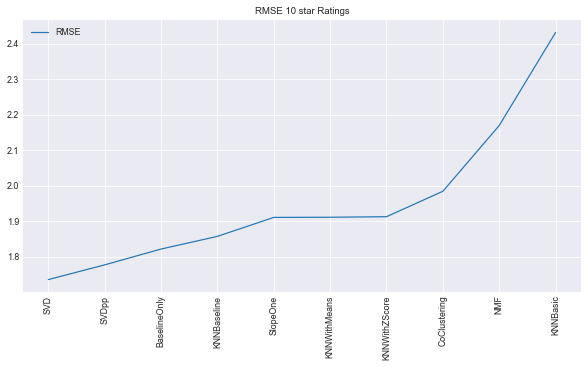

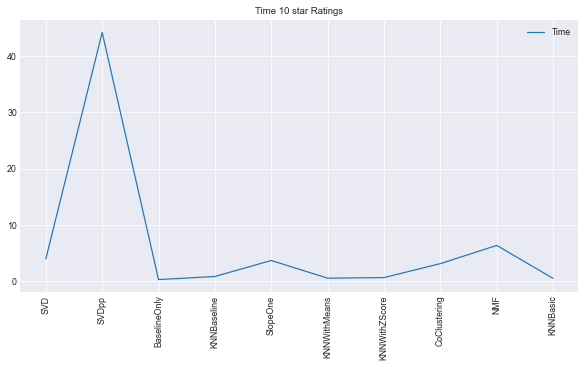

In [352]:
#ploting models RMSE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(surprise_results_1to10['test_rmse'],label='RMSE')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('RMSE 10 star Ratings')
    fig.savefig('./figs/RMSE 10 star Ratings.jpg')
    plt.show()
#ploting models Time
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(surprise_results_1to10['fit_time'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('Time 10 star Ratings')
    fig.savefig('./figs/Time 10 star Ratings.jpg')
    plt.show()

In [ ]:
# Export the results as csv file
surprise_results_1to10.to_csv('surprise_results_1to10.csv')

In [ ]:
# Average calculation for values of surprise_results_1to10
surprise_results_1to10[["test_rmse","test_mae","fit_time","test_time"]].mean()

### Ratings 1 - 5
 Run 5-fold cross-validation and print results for NMF(), SlopeOne(), SVDpp(), SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly() and CoClustering().

Code Reference: https://gist.github.com/susanli2016/e0cdcf1bca69a2b144fd8c04f30b522f

In [155]:
# Create the data frame from the userID, artistID and ratings_10 variables from user_artist data table
data=pd.DataFrame()
data['userID']=user_artists['userID']
data['artistID']=user_artists['artistID']
data['ratings']=user_artists['ratings_5']

# Reader rating scale setup 1 for lowest and 5 for highest
datas = Reader(rating_scale=(1, 5))
data_sup=Dataset.load_from_df(data,datas)

In [156]:
benchmark_5 = []

# Iterate over all algorithms

algorithms = [NMF(), SlopeOne(), SVDpp(), SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    results2 = cross_validate(algorithm, data_sup, measures=['RMSE', 'MAE'], cv=5, verbose=False)  # Perform cross validation    
    tmp = pd.DataFrame.from_dict(results2).mean(axis=0) # Get results & append algorithm name
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark_5.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000252BAD5D130>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x00000252BAD5D880>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x00000252BAD8FFA0>, <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000252BAD8FBE0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x00000252BAD8FE50>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x00000252BAD8FE20>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000252BAA6A460>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x00000252BAA6AB80>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x00000252BAD3F850>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x00000252BAD3F6D0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000252BAD5D130>
Done:  <surprise.prediction_algorith

In [224]:
# Display the results
surprise_results_1to5 = pd.DataFrame(benchmark_5).set_index('Algorithm').sort_values('test_rmse')
# 
surprise_results_1to5

Algorithm,SVDpp,SVD,BaselineOnly,KNNBaseline,KNNWithMeans,KNNWithZScore,SlopeOne,CoClustering,NMF,KNNBasic
test_rmse,0.860708,0.873919,0.919788,0.937700,0.956269,0.959870,0.964033,0.995741,1.020504,1.232800
test_mae,0.661348,0.686110,0.763503,0.748354,0.729534,0.729456,0.730494,0.760994,0.773099,1.006724
fit_time,42.260563,3.939329,0.277142,0.722294,0.496191,0.603259,3.994175,2.877320,6.315010,0.466769
test_time,0.798311,0.119886,0.074662,1.854093,1.668215,1.832847,0.680081,0.085572,0.122628,1.556624


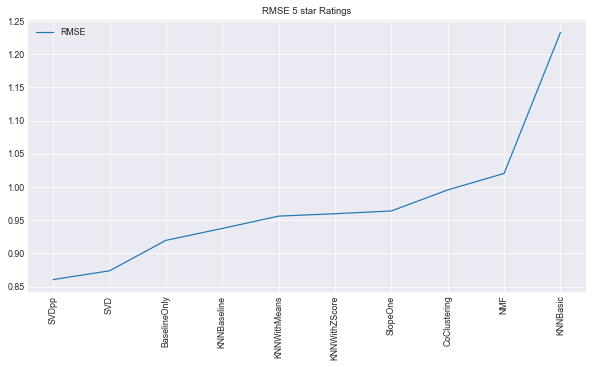

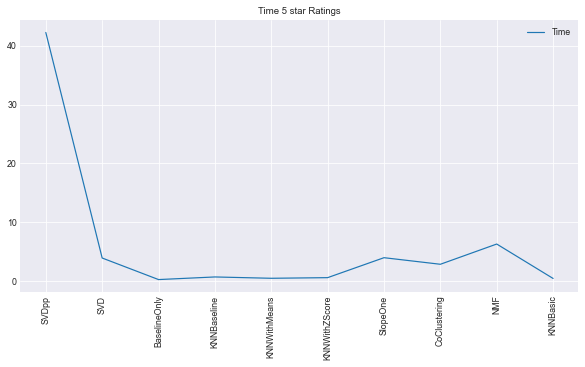

In [353]:
#ploting models RMSE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(surprise_results_1to5['test_rmse'],label='RMSE')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('RMSE 5 star Ratings')
    fig.savefig('./figs/RMSE 5 star Ratings.jpg')
    plt.show()
#ploting models Time
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(surprise_results_1to5['fit_time'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('Time 5 star Ratings')
    fig.savefig('./figs/Time 5 star Ratings.jpg')
    plt.show()

In [ ]:
# Average calculation for values of surprise_results_1to5
surprise_results_1to5[["test_rmse","test_mae","fit_time","test_time"]].mean()

In [ ]:
# Export the results as csv file
surprise_results_1to5.to_csv('surprise_results_1to5.csv')

### Model Evaluation
After obtaining the RMSE, MAE, FIT_TEST and TEST_TIME we clearly see that the best performance is made in the population segmented in ratings from 1 to 5. That being said, we will base our prediction calculations of our models, using this dataset.

In [158]:
# Create our train and test set for our model predictions.
# Base data frame from the userID, artistID and ratings_10 variables from user_artist data table
data=pd.DataFrame()
data['userID']=user_artists['userID']
data['artistID']=user_artists['artistID']
data['ratings']=user_artists['ratings_5']
# Reader rating scale setup 1 for lowest and 5 for highest
datas = Reader(rating_scale=(1, 5))
data_sup=Dataset.load_from_df(data,datas)
# Split the data in train and test
train_df,test_df=train_test_split(data,test_size=0.2,random_state=613)
train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
datas = Reader(rating_scale=(1, 5))
train=Dataset.load_from_df(train_df,datas).build_full_trainset()
test=list(test_df.itertuples(index=False,name=None))

In [159]:
# SVD++ Model Prediction
svdpp = SVDpp()
svdpp.fit(train)
prediction_svdpp=svdpp.test(test)

In [160]:
# SVD Model Prediction
svd = SVD()
svd.fit(train)
prediction_svd=svd.test(test)

In [161]:
# BaselineOnly Model Prediction
baselineonly = BaselineOnly()
baselineonly.fit(train)
prediction_baselineonly=baselineonly.test(test)

Estimating biases using als...


In [162]:
# KNNBaseline Model Prediction
KNNB = KNNBaseline()
KNNB.fit(train)
prediction_KNNBaseline=KNNB.test(test)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


#### prediction evaluation

In [163]:
# SVD++ Prediction Evaluation
eval_svdpp=eval.evaluate(prediction=prediction_svdpp,topn=15,rating_cutoff=0.70,excl_impossible=True)
# SVD Prediction Evaluation
eval_svd=eval.evaluate(prediction=prediction_svd,topn=15,rating_cutoff=0.70,excl_impossible=True)
# BaselineOnly Prediction Evaluation
eval_baselineonly=eval.evaluate(prediction=prediction_baselineonly,topn=15,rating_cutoff=0.70,excl_impossible=True)
# KNNBaseline Prediction Evaluation
eval_knnbaseline=eval.evaluate(prediction=prediction_KNNBaseline,topn=15,rating_cutoff=0.70,excl_impossible=True)

Excluded 0 (17322) samples. 17322 remaining ...
Excluded 0 (17322) samples. 17322 remaining ...
Excluded 0 (17322) samples. 17322 remaining ...
Excluded 0 (17322) samples. 17322 remaining ...
Excluded 0 (17322) samples. 17322 remaining ...
Excluded 0 (17322) samples. 17322 remaining ...
Excluded 0 (17322) samples. 17322 remaining ...
Excluded 0 (17322) samples. 17322 remaining ...


In [164]:
# Putting all togheter in the same data frame 
all_evals=pd.DataFrame(eval_svdpp)
all_evals['SVD++']=eval_svdpp['value']
all_evals['SVD']=eval_svd['value']
all_evals['BaselineOnly']=eval_baselineonly['value']
all_evals['KNNBaseline']=eval_knnbaseline['value']
all_evals=all_evals.drop(['value'],axis=1)
all_evals

,SVD++,SVD,BaselineOnly,KNNBaseline
RMSE,0.860669,0.872696,0.920324,0.934615
MAE,0.661988,0.684540,0.763314,0.745831
Recall,1.000000,1.000000,1.000000,1.000000
Precision,1.000000,1.000000,1.000000,1.000000
F1,1.000000,1.000000,1.000000,1.000000
NDCG@15,0.833019,0.829420,0.831267,0.829694


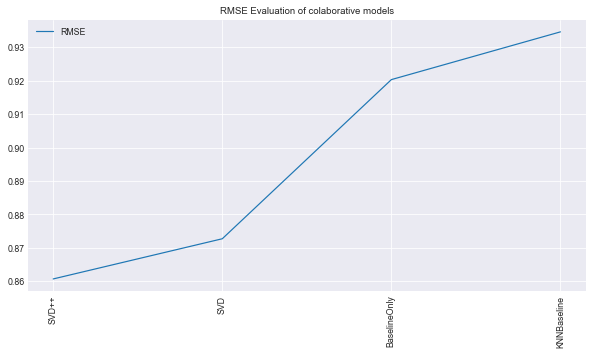

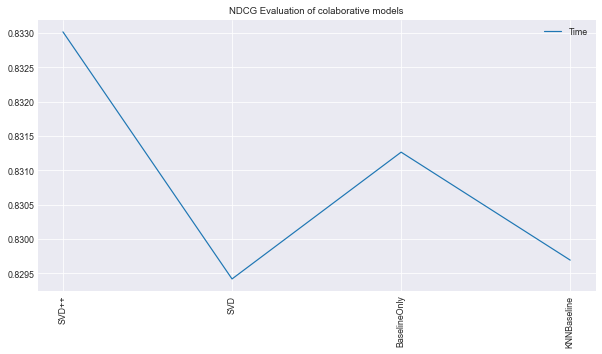

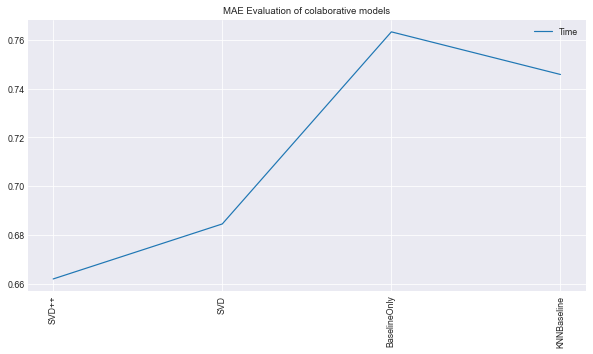

In [354]:
#ploting models RMSE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(all_evals.T['RMSE'],label='RMSE')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('RMSE Evaluation of colaborative models')
    fig.savefig('./figs/RMSE Evaluation of colaborative models.jpg')
    plt.show()
#ploting models NDCG
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(all_evals.T['NDCG@15'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('NDCG Evaluation of colaborative models')
    fig.savefig('./figs/NDCG Evaluation of colaborative models.jpg')
    plt.show()
#ploting models MAE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(all_evals.T['MAE'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('MAE Evaluation of colaborative models')
    fig.savefig('./figs/MAE Evaluation of colaborative models.jpg')
    plt.show()


In [ ]:
# Export all_evals as .csv file
all_evals.to_csv('all_evals.csv')

## Content Base Recomendation

In [179]:
# merging user_taggedartists with tags data
user_taggedartists_tags = pd.merge(user_taggedartists, tags,how='inner', on = 'tagID')

In [181]:
#Aggregating the merged data
dt_a = user_taggedartists_tags.groupby('artistID',as_index=False).agg({'tagValue':'unique','userID':'count'})
dt_a['tagValue']=dt_a['tagValue'].astype(str).str[1:-1]
dt_a.head()

,artistID,tagValue,userID
0,1,'j-rock' 'visual kei' 'gothic' 'japanese' 'wee...,15
1,2,'electronic' 'ambient' 'seen live' 'german' 'i...,27
2,3,'black metal' 'norwegian black metal' 'true no...,9
3,4,'rock' 'metal' 'gothic metal' 'j-rock' 'visual...,22
4,5,'gothic' 'gothic rock' 'darkwave' 'deathrock' ...,7


In [417]:
dt_a.shape

(12523, 3)

In [182]:
# Tokenize, case conversion & only alphabetic
tokens = dt_a['tagValue'].apply(lambda txt: [word.lower() for word in word_tokenize(str(txt)) if word.isalpha()])

stemmer = SnowballStemmer("english")

# remove stopwords, stem
token_stem = tokens.apply(lambda lst_token: [stemmer.stem(tok) for tok in lst_token if len(tok) > 2])

In [184]:
# TFIDF vectorizer
tfidf = TfidfVectorizer(min_df=5)

# apply tf-idf vectorizer -> document-term-matrix in sparse format
dtm = tfidf.fit_transform([" ".join(x) for x in tokens])

print(dtm.shape)

df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names(), index=dt_a.artistID)
df_dtm.head()

(12523, 858)


,about,absolutely,acoustic,actually,adam,africa,african,again,against,age,...,yet,york,yorkshire,you,young,your,youre,yourself,zealand,zone
artistID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
# content-based
cb = ContentBased(NN=10)
cb.fit(df_dtm)
cb.fit_ratings(train)
cb_pred = cb.test(test)

# item-based
options = {'name':'cosine', 'user_based':False}
ib = KNNBasic()
ib.fit(train)
ib_pred = ib.test(test)

# svd
svd = SVD()
svd.fit(train)
svd_pred = svd.test(test)

# svd()
svdpp = SVDpp()
svdpp.fit(train)
svdpp_pred = svdpp.test(test)

models = {"Content Based":cb_pred, "Item Based":ib_pred, "SVD":svd_pred, "SVD++": svdpp_pred}
overview = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=5) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

,Content Based,Item Based,SVD,SVD++
RMSE,0.968024,1.229307,0.874933,0.863877
MAE,0.738589,1.003038,0.686909,0.664642
Recall,0.126893,0.007716,0.057159,0.087739
Precision,0.940678,0.173077,0.909091,0.916418
F1,0.223621,0.014774,0.107556,0.160146
NDCG@5,0.866486,0.841275,0.841735,0.845711


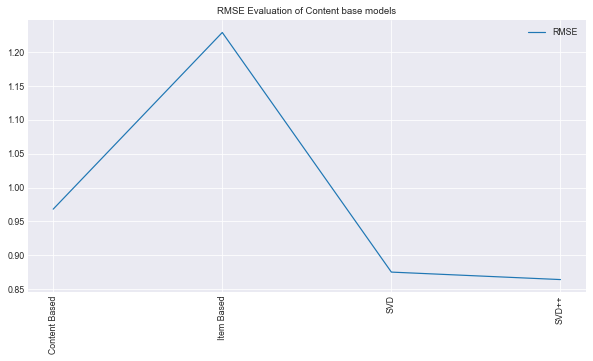

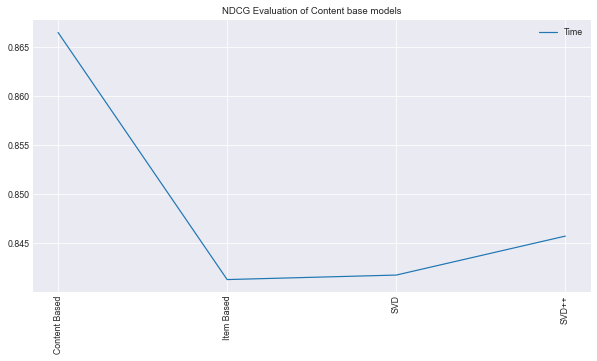

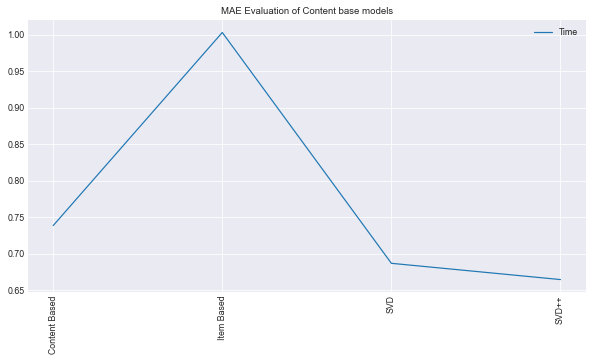

In [356]:
#ploting models RMSE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview.T['RMSE'],label='RMSE')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('RMSE Evaluation of Content base models')
    fig.savefig('./figs/RMSE Evaluation of Content base models.jpg')
    plt.show()
#ploting models NDCG
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview.T['NDCG@5'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('NDCG Evaluation of Content base models')
    fig.savefig('./figs/NDCG Evaluation of Content base models.jpg')
    plt.show()
#ploting models MAE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview.T['MAE'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('MAE Evaluation of Content base models')
    fig.savefig('./figs/MAE Evaluation of Content base models.jpg')
    plt.show()


## Hybrid Recomendation System

### Combination of different models

In [198]:
#Converting all predictions to dataframes
df_cb_pred = pd.DataFrame(cb_pred)
df_ib_pred = pd.DataFrame(ib_pred)
svd_pred = pd.DataFrame(svd_pred)
svdpp_pred = pd.DataFrame(svdpp_pred)

In [199]:
# Combine predictions (mean of two model content and item base)
df_hybrid = df_cb_pred.copy()
df_hybrid['est'] = (np.array(df_cb_pred['est']) + np.array(df_ib_pred['est'])) / 2

df_hybrid.head()

,uid,iid,r_ui,est,details
0,252,689,5,3.887144,{'was_impossible': False}
1,1718,1833,5,3.260324,{'was_impossible': False}
2,810,972,2,1.784216,{'was_impossible': False}
3,607,4271,2,2.378094,{'was_impossible': False}
4,1293,2956,1,1.735391,{'was_impossible': False}


In [202]:
# Combine predictions (mean of two model content and svd)
df_hybrid_2 = df_cb_pred.copy()
df_hybrid_2['est'] = (np.array(df_cb_pred['est']) + np.array(svd_pred['est'])) / 2

df_hybrid_2.head()

,uid,iid,r_ui,est,details
0,252,689,5,3.787233,{'was_impossible': False}
1,1718,1833,5,3.196544,{'was_impossible': False}
2,810,972,2,1.543711,{'was_impossible': False}
3,607,4271,2,2.536770,{'was_impossible': False}
4,1293,2956,1,1.318772,{'was_impossible': False}


In [203]:
# Combine predictions (mean of two model content and svdpp)
df_hybrid_3 = df_cb_pred.copy()
df_hybrid_3['est'] = (np.array(df_cb_pred['est']) + np.array(svdpp_pred['est'])) / 2

df_hybrid_3.head()

,uid,iid,r_ui,est,details
0,252,689,5,3.922304,{'was_impossible': False}
1,1718,1833,5,3.156458,{'was_impossible': False}
2,810,972,2,1.328336,{'was_impossible': False}
3,607,4271,2,2.579065,{'was_impossible': False}
4,1293,2956,1,1.393842,{'was_impossible': False}


In [204]:
# Combine predictions (mean of 4 model)
df_hybrid_4 = df_cb_pred.copy()
df_hybrid_4['est'] = (np.array(df_cb_pred['est']) + np.array(df_ib_pred['est'])\
    +np.array(svd_pred['est']) + np.array(svdpp_pred['est'])) / 4

df_hybrid_4.head()

,uid,iid,r_ui,est,details
0,252,689,5,3.811498,{'was_impossible': False}
1,1718,1833,5,3.083871,{'was_impossible': False}
2,810,972,2,1.640631,{'was_impossible': False}
3,607,4271,2,2.455298,{'was_impossible': False}
4,1293,2956,1,1.525541,{'was_impossible': False}


In [205]:
models = {"Hybrid 1":df_hybrid, "Hybrid 2":df_hybrid_2, "Hybrid 3":df_hybrid_3, "Hybrid 4": df_hybrid_4}
overview_HY = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=5) for mod in models.values()], axis=1)
overview_HY.columns = list(models.keys())
overview_HY

,Hybrid 1,Hybrid 2,Hybrid 3,Hybrid 4
RMSE,0.882216,0.891036,0.882216,0.906234
MAE,0.689717,0.701707,0.689717,0.738359
Recall,0.042298,0.028865,0.042298,0.000000
Precision,1.000000,1.000000,1.000000,NaN
F1,0.081163,0.056111,0.081163,NaN
NDCG@5,0.844162,0.841248,0.844162,0.842155


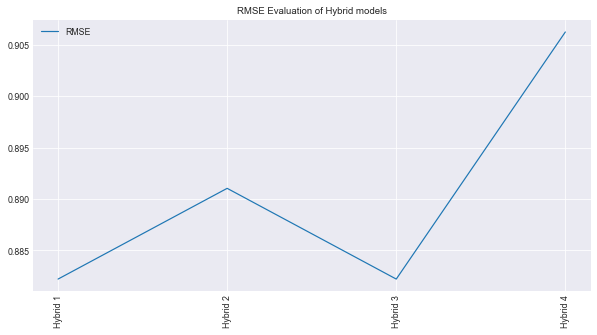

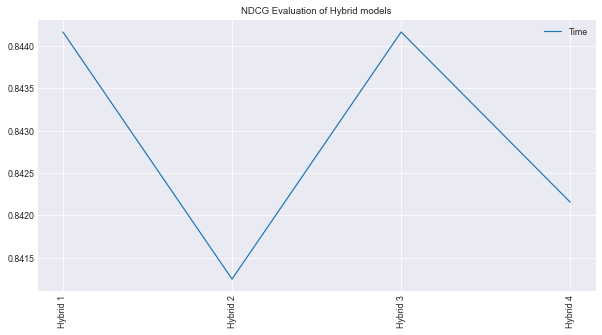

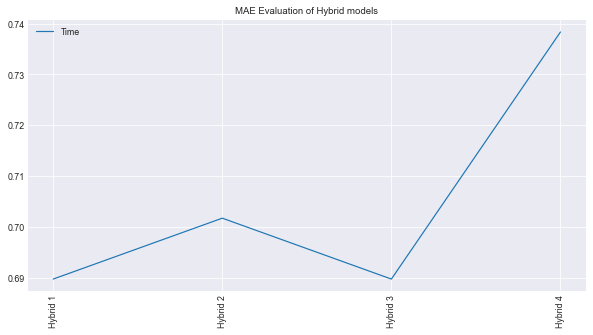

In [357]:
#ploting models RMSE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview_HY.T['RMSE'],label='RMSE')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('RMSE Evaluation of Hybrid models')
    fig.savefig('./figs/RMSE Evaluation of Hybrid models.jpg')
    plt.show()
#ploting models NDCG
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview_HY.T['NDCG@5'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('NDCG Evaluation of Hybrid models')
    fig.savefig('./figs/NDCG Evaluation of Hybrid models.jpg')
    plt.show()
#ploting models MAE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview_HY.T['MAE'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('MAE Evaluation of Hybrid models')
    fig.savefig('./figs/MAE Evaluation of Hybrid models.jpg')
    plt.show()



### Hybrid and Prediction Models

In [491]:
# setting all the model predictions as dataframe
predictions_df = df_ib_pred[['r_ui', 'est']].rename(columns={'r_ui':'ratings_5', 'est':'Item Based'})
predictions_df['SVD'] = svd_pred['est']
predictions_df['SVD++'] = svdpp_pred['est']
predictions_df['Content Based'] = df_cb_pred['est']
predictions_df

,ratings_5,Item Based,SVD,SVD++,Content Based
0,5,3.800604,3.600781,3.870923,3.973684
1,5,3.075065,2.947504,2.867333,3.445583
2,2,2.193432,1.712421,1.281672,1.375000
3,2,2.172855,2.490207,2.574798,2.583333
4,1,2.073858,1.240620,1.390760,1.396925
...,...,...,...,...,...
17317,1,1.679267,1.865878,2.765160,1.543086
17318,2,3.665957,3.365740,3.011575,2.627959
17319,3,3.615619,3.499610,3.642287,3.615385
17320,2,1.000000,3.223507,3.008366,3.156250


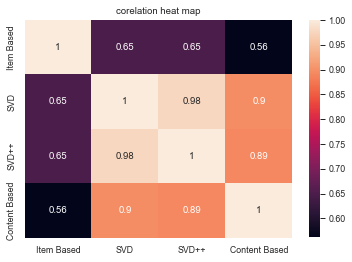

In [487]:
#Correlation matrix
corrMatrix = predictions_df[['Item Based', 'SVD', 'SVD++', 'Content Based']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('corelation heat map')
plt.savefig('./figs/corelation heat map.jpg')
plt.show()

In [488]:
#Selected columns
selected_columns = ['SVD', 'Item Based', 'Content Based']

In [209]:
#Train test split for linear regression
prediction_train_x, prediction_test_x, prediction_train_y, prediction_test_y = train_test_split(predictions_df[selected_columns],
                                                                                               predictions_df['ratings_5'],
                                                                                               test_size = 0.2, random_state = 613)

# Train Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
#fit the model
lr_model = LinearRegression().fit(prediction_train_x,prediction_train_y)

# predict
lr_pred = lr_model.predict(prediction_test_x)

lr_pred_all = lr_model.predict(predictions_df[selected_columns])

# transform in surprise format
df_lr = df_ib_pred.copy()
df_lr['est'] = lr_pred_all

In [481]:
#Train test split for linear regression
prediction_train_x, prediction_test_x, prediction_train_y, prediction_test_y = train_test_split(predictions_df[selected_columns],
                                                                                               predictions_df['ratings_5'],
                                                                                               test_size = 0.2, random_state = 613)

# Train Linear Regression model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
#fit the model
GB_model = GradientBoostingClassifier().fit(prediction_train_x,prediction_train_y)

# predict
GB_pred = GB_model.predict(prediction_test_x)

GB_pred_all = GB_model.predict(predictions_df[selected_columns])

# transform in surprise format
df_GB = df_ib_pred.copy()
df_GB['est'] = GB_pred_all

In [492]:
#Pusing the liner regression predictions to predictions_df dataframe
lr_pred_all = pd.DataFrame(lr_pred_all)
lr_pred_all.columns = ['Linear Regression']
GB_pred_all = pd.DataFrame(GB_pred_all)
GB_pred_all.columns = ['Boosted Tree']
predictions_df = pd.concat([predictions_df, lr_pred_all,GB_pred_all, df_hybrid['est']], axis = 1)

In [494]:
#rmse of each model
models = {"Content Based":cb_pred, "Artist Based":ib_pred, "SVD":svd_pred, "SVD++": svdpp_pred, 'Hybrid_IB_SVD':df_hybrid,
          'Hybrid_Linear_regression':df_lr,'Boosted Tree':df_GB}
overview_HY2 = pd.concat([eval.evaluate(mod, topn=5, rating_cutoff=5) for mod in models.values()], axis=1)
overview_HY2.columns = list(models.keys())
overview_HY2

,Content Based,Artist Based,SVD,SVD++,Hybrid_IB_SVD,Hybrid_Linear_regression,Boosted Tree
RMSE,0.968024,1.229307,0.874933,0.863877,0.882216,0.867995,0.976960
MAE,0.738589,1.003038,0.686909,0.664642,0.689717,0.669459,0.587288
Recall,0.126893,0.007716,0.057159,0.087739,0.042298,0.106316,0.540440
Precision,0.940678,0.173077,0.909091,0.916418,1.000000,0.930000,0.715204
F1,0.223621,0.014774,0.107556,0.160146,0.081163,0.190818,0.615660
NDCG@5,0.866486,0.841275,0.841735,0.845711,0.844162,0.840912,0.907446


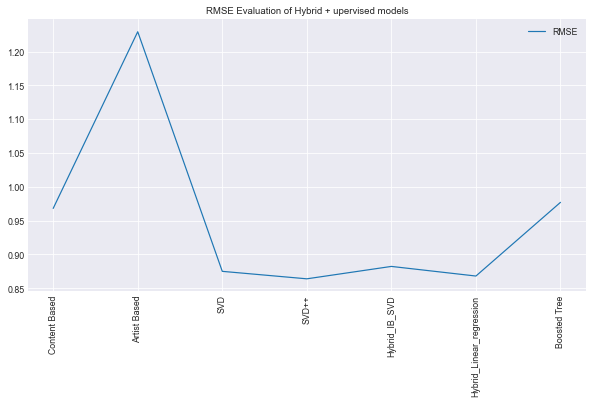

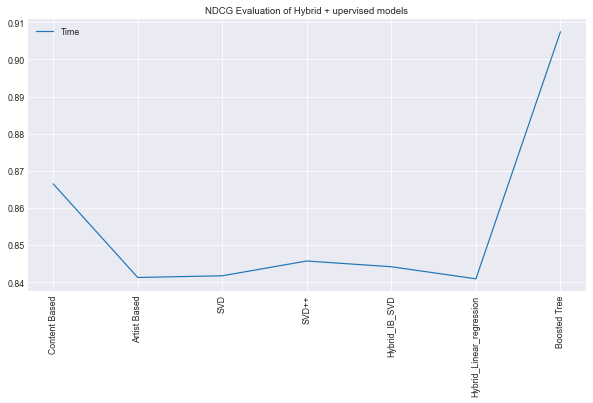

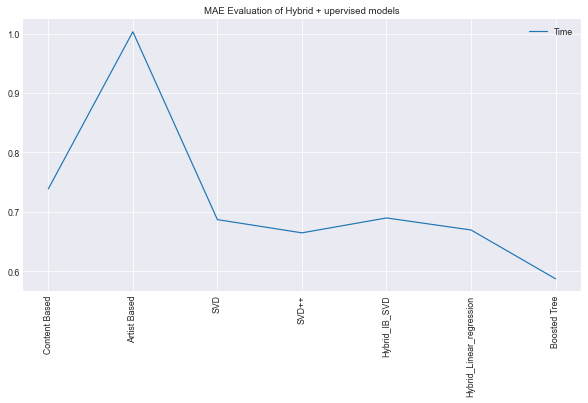

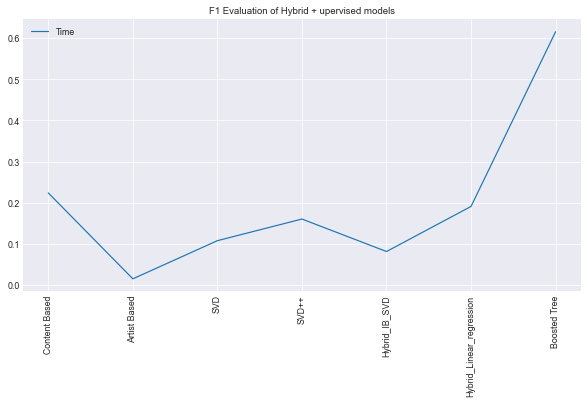

In [504]:
#ploting models RMSE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.col(overview_HY2.T['RMSE'],label='RMSE')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('RMSE Evaluation of Hybrid + upervised models')
    fig.savefig('./figs/RMSE Evaluation of Hybrid + upervised models.jpg')
    plt.show()
#ploting models NDCG
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview_HY2.T['NDCG@5'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('NDCG Evaluation of Hybrid + upervised models')
    fig.savefig('./figs/NDCG Evaluation of Hybrid + upervised models.jpg')
    plt.show()
#ploting models MAE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview_HY2.T['MAE'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('MAE Evaluation of Hybrid + upervised models')
    fig.savefig('./figs/MAE Evaluation of Hybrid + upervised models.jpg')
    plt.show()
#ploting models MAE
with plt.style.context('seaborn-darkgrid'):
    fig, axes = plt.subplots( figsize=(10, 5), sharey=True)
    plt.plot(overview_HY2.T['F1'],label='Time')
    plt.xticks(rotation = 90)
    plt.legend()
    plt.title('F1 Evaluation of Hybrid + upervised models')
    fig.savefig('./figs/F1 Evaluation of Hybrid + upervised models.jpg')
    plt.show()

In [ ]:
overview_HY2.to_csv('./Data-20220224/Data Group Assignment/overview_scores.csv')

# Analyzing the Results
here we will analyze the results of recomendation model and real dataset similarities

In [249]:
# Create the data frame from the userID, artistID and ratings_10 variables from user_artist data table
data_M=pd.DataFrame()
data_M['userID']=user_artists['userID']
data_M['artistID']=user_artists['artistID']
data_M['ratings']=user_artists['ratings_5']

In [294]:
#Creating user base matrix
UB_M=data_M.pivot_table(index=['userID'],values=['ratings'],columns=['artistID'])
UB_M=UB_M.reset_index(drop=True)
#calculatin cosin similarity for users
matrix_user=cosine_similarity(UB_M.fillna(0))
#calculating cosin distance for users
matrix_user_D=cosine_distances(UB_M.fillna(0))


In [330]:
# which users have the hiest similarity from the user we select?
UMM=pd.DataFrame(matrix_user)
UMM.loc[UMM[13]<1,[1]].sort_values(by=1,ascending=False).head(10).T

,1,57,398,417,238,484,1568,1780,1706,593
1,1.0,0.126428,0.084601,0.072443,0.070703,0.068212,0.067264,0.062937,0.061649,0.053622


In [334]:
# which users have the hiest distance from the user we select?
# we disregard the users distance equal to 1 since they have no relationship
UMM_D=pd.DataFrame(matrix_user_D)
UMM_D.loc[UMM_D[1]<1,[1]].sort_values(by=1,ascending=False).head(10).T

,754,850,1890,538,727,882,810,1362,480,1250
1,0.994624,0.9918,0.99036,0.989859,0.982468,0.980587,0.980543,0.980073,0.979718,0.977847


In [305]:
# which user have the least distance from other users?
UMM_D[min(UMM_D.mean())==UMM_D.mean()]

,0,1,2,3,4,5,6,7,8,9,...,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891
980,0.896424,1.0,0.953255,0.968968,0.970608,0.420758,0.666914,0.960537,0.986706,0.649002,...,1.0,0.960189,1.0,1.0,0.844213,1.0,0.987507,0.987877,1.0,1.0


In [298]:
#Creating item base matrix
AB_M=data_M.pivot_table(index=['artistID'],values=['ratings'],columns=['userID'])
AB_M=AB_M.reset_index(drop=True)
#calculatin cosin similarity for items
matrix_artist=cosine_similarity(AB_M.fillna(0))
#calculating cosin distance for items
matrix_artist_D=cosine_distances(AB_M.fillna(0))

In [473]:
# which artist have the hiest similarity from the artist we select?
ABB=pd.DataFrame(matrix_artist)
ABB.loc[ABB[908]<1,[908]].sort_values(by=908,ascending=False).head(10).T

,908,896,913,1686,893,892,44,777,894,153
908,1.0,0.655472,0.620731,0.502918,0.496456,0.482954,0.469619,0.466722,0.459217,0.440541


In [474]:
cb.get_most_similar( 908, topn=10)

array([5955,  461,   89, 1593, 1684,  523,  538,  325,  681,  293],
      dtype=int64)

In [300]:
# which artist have the hiest distance from the item we select?
# we disregard the artist distance equal to 1 since they have no relationship
ABB_D=pd.DataFrame(matrix_artist_D)
ABB_D.loc[ABB_D[1]<1,[1]].sort_values(by=1,ascending=False).head(10).T

,444,457,44,374,896,492,1526,908,164,2656
1,0.998946,0.998237,0.997914,0.997888,0.997771,0.9968,0.996792,0.996776,0.996624,0.996246


In [304]:
# which artist have the least distance from other artists?
ABB_D[min(ABB_D.mean())==ABB_D.mean()]

,0,1,2,3,4,5,6,7,8,9,...,12123,12124,12125,12126,12127,12128,12129,12130,12131,12132
192,0.960028,0.971741,1.0,1.0,0.961635,0.951354,0.828663,0.954424,0.935468,0.976022,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## TOP 10 RECOMMENDATIONS

In [177]:
def predict_user_topn(model, train, user, topk=10, item_col='artistID'):
    """
    Returns topk items for specified user.
    Return type: list

    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids 
    """

    # intermediate result dict 
    res = {item_col:[], 'pred':[], 'detail':[]}
    
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

In [321]:
# Create our train and test set for our model predictions.
# Base data frame from the userID, artistID and ratings_10 variables from user_artist data table
data=pd.DataFrame()
data['userID']=user_artists['userID']
data['artistID']=user_artists['artistID']
data['ratings']=user_artists['ratings_5']
# Reader rating scale setup 1 for lowest and 5 for highest
datas = Reader(rating_scale=(1, 5))
train_sup=Dataset.load_from_df(data,datas).build_full_trainset()
# SVD++ Model Prediction
svdpp = SVDpp()
svdpp.fit(train_sup)
# SVD Model Prediction
svd = SVD()
svd.fit(train_sup)
# BaselineOnly Model Prediction
baselineonly = BaselineOnly()
baselineonly.fit(train_sup)
# content-based
cb = ContentBased(NN=10)
cb.fit(df_dtm)
cb.fit_ratings(train_sup)

Estimating biases using als...


In [328]:

res = {}
for model in (cb,baselineonly, svd, svdpp):
    pred = predict_user_topn(model, train_df, 13, topk=10, item_col='artistID')
    res[model] = pred
res=pd.DataFrame(res)
res.columns = ['Content Base','Base Line','SVD','SVDpp']
res

,Content Base,Base Line,SVD,SVDpp
0,908,289,89,89
1,1246,292,375,289
2,72,72,289,1904
3,292,89,72,744
4,681,288,1904,635
5,461,679,816,288
6,344,1904,6724,6733
7,300,816,744,6724
8,227,375,233,233
9,289,2102,2102,7994


In [464]:
# artists names for content base recomendation
Recomendation_for_u_13_ContentBase=pd.DataFrame()
Recomendation_for_u_13_ContentBase['artistID']=res['Content Base']
RC13=Recomendation_for_u_13_ContentBase.merge(BaseTable,how='inner',on='artistID')
RC13=RC13.groupby('name',as_index=False).agg({'name':'unique','tagValue':'unique'})
Recomendation_for_u_13_ContentBase['name']=RC13['name'].astype(str).str[1:-1].astype(str)
Recomendation_for_u_13_ContentBase['tagValue']=RC13['tagValue'].astype(str).str[4:-1].astype(str)
Recomendation_for_u_13_ContentBase

,artistID,name,tagValue
0,908,'Britney Spears','pop' 'dance' 'rock' 'alternative' 'seen live...
1,1246,'Christina Aguilera','pop' 'legend' 'talent' 'electronic' 'dance' ...
2,72,'Demi Lovato','disney' 'pop' 'dance' 'rock' 'female vocalis...
3,292,'Depeche Mode',"'electronic' 'industrial' 'new wave' ""80's"" '..."
4,681,'Katy Perry','pop' 'pop rock' 'alternative rock' 'electro ...
5,461,'Miley Cyrus','electro pop' 'teen pop' 'disney' 'country po...
6,344,'Panic! At the Disco','summer' '<3' 'love at first listen' 'these g...
7,300,'Taylor Swift','pop' 'singer-songwriter' 'acoustic' 'country...
8,227,'The Beatles',"'classic rock' 'dance' 'rock' ""60's"" 'pop' 'b..."
9,289,'Vanessa Hudgens','teen pop' 'disney' 'female vocalists' 'amazi...


In [467]:
# artists names for BaseLine recomendation
Recomendation_for_u_13_Base_Line=pd.DataFrame()
Recomendation_for_u_13_Base_Line['artistID']=res['Base Line']
RC13=Recomendation_for_u_13_Base_Line.merge(BaseTable,how='inner',on='artistID')
RC13=RC13.groupby('name',as_index=False).agg({'name':'unique','tagValue':'unique'})
Recomendation_for_u_13_Base_Line['name']=RC13['name'].astype(str).str[1:-1].astype(str)
Recomendation_for_u_13_Base_Line['tagValue']=RC13['tagValue'].astype(str).str[4:-1].astype(str)
Recomendation_for_u_13_Base_Line

,artistID,name,tagValue
0,289,'A Day to Remember','post-hardcore' 'hardcore' 'pop punk' 'scream...
1,292,'Britney Spears','pop' 'dance' 'rock' 'alternative' 'seen live...
2,72,'Christina Aguilera','pop' 'legend' 'talent' 'electronic' 'dance' ...
3,89,'Depeche Mode',"'electronic' 'industrial' 'new wave' ""80's"" '..."
4,288,'Glee Cast','glee' 'musical' 'pop' 'party' 'cover' 'roman...
5,679,'Lady Gaga','pop' 'electronic' 'dance' 'female vocalist' ...
6,1904,'Rihanna',en live' 'hit' nan 'pop' 'dance' 'rnb' 'electr...
7,816,'SHINee','pop' 'kpop' 'k-pop' 'korean' 'heart' 'myfavo...
8,375,'倖田來未','performer' 'entertainer' 'jpop' 'taboo' 'j-c...
9,2102,'浜崎あゆみ',pop' nan 'jpop' 'it could be so much better'\n...


In [468]:
# artists names for BaseLine recomendation
Recomendation_for_u_13_SVD=pd.DataFrame()
Recomendation_for_u_13_SVD['artistID']=res['SVD']
RC13=Recomendation_for_u_13_SVD.merge(BaseTable,how='inner',on='artistID')
RC13=RC13.groupby('name',as_index=False).agg({'name':'unique','tagValue':'unique'})
Recomendation_for_u_13_SVD['name']=RC13['name'].astype(str).str[1:-1].astype(str)
Recomendation_for_u_13_SVD['tagValue']=RC13['tagValue'].astype(str).str[4:-1].astype(str)
Recomendation_for_u_13_SVD

,artistID,name,tagValue
0,89,'A Day to Remember','post-hardcore' 'hardcore' 'pop punk' 'scream...
1,375,'Autechre','ambient' 'experimental' 'idm' 'minimal' 'ele...
2,289,'Britney Spears','pop' 'dance' 'rock' 'alternative' 'seen live...
3,72,'Depeche Mode',"'electronic' 'industrial' 'new wave' ""80's"" '..."
4,1904,'John Frusciante','awesome guitar jams' 'indie' 'beautiful' 'fa...
5,816,'Lady Gaga','pop' 'electronic' 'dance' 'female vocalist' ...
6,6724,'Nine Inch Nails',nter' nan 'industrial' 'industrial pop' 'melan...
7,744,'SHINee','pop' 'kpop' 'k-pop' 'korean' 'heart' 'myfavo...
8,233,'倖田來未','performer' 'entertainer' 'jpop' 'taboo' 'j-c...
9,2102,'浜崎あゆみ',pop' nan 'jpop' 'it could be so much better'\n...


In [469]:
# artists names for BaseLine recomendation
Recomendation_for_u_13_SVDpp=pd.DataFrame()
Recomendation_for_u_13_SVDpp['artistID']=res['SVDpp']
RC13=Recomendation_for_u_13_SVDpp.merge(BaseTable,how='inner',on='artistID')
RC13=RC13.groupby('name',as_index=False).agg({'name':'unique','tagValue':'unique'})
Recomendation_for_u_13_SVDpp['name']=RC13['name'].astype(str).str[1:-1].astype(str)
Recomendation_for_u_13_SVDpp['tagValue']=RC13['tagValue'].astype(str).str[4:-1].astype(str)
Recomendation_for_u_13_SVDpp

,artistID,name,tagValue
0,89,'Autechre','ambient' 'experimental' 'idm' 'minimal' 'ele...
1,289,'Britney Spears','pop' 'dance' 'rock' 'alternative' 'seen live...
2,1904,'John Frusciante','awesome guitar jams' 'indie' 'beautiful' 'fa...
3,744,'Lady Gaga','pop' 'electronic' 'dance' 'female vocalist' ...
4,635,'Nine Inch Nails',nter' nan 'industrial' 'industrial pop' 'melan...
5,288,'Rihanna',en live' 'hit' nan 'pop' 'dance' 'rnb' 'electr...
6,6733,'SHINee','pop' 'kpop' 'k-pop' 'korean' 'heart' 'myfavo...
7,6724,'Savoy',erican' 'norwegian' nan
8,233,'Sergey Lazarev','pop' 'hot' '<3' 'russian' 'male vocalist' 's...
9,7994,'Teen Angels',p' 'pop-rock' 'spanish' nan 'latin' 'casi ange...


## Cheking Similarity of Tags
here we get the tags for two artists for content base approch to be sure there are similarities between sugested artists

In [475]:
pd.DataFrame(cb.get_most_similar( 908, topn=10))

,0
0,5955
1,461
2,89
3,1593
4,1684
5,523
6,538
7,325
8,681
9,293


In [463]:
user_taggedartists_tags[user_taggedartists_tags['artistID']==1246]\
    .groupby('artistID',as_index=False).agg({'tagValue':'unique'})

        

,artistID,tagValue
0,1246,"[dance, pop, rock, alternative, alternative ro..."


In [399]:
user_taggedartists_tags[user_taggedartists_tags['artistID']==908]\
    .groupby('artistID',as_index=False).agg({'tagValue':'unique','userID':'count'})

,artistID,tagValue,userID
0,908,"[dance, pop, female vocalist, rock, female voc...",91


## Analyzing Results for 1 User

In [416]:
UMM.loc[UMM[13]<1,[1]].sort_values(by=1,ascending=False).head(11).T

,1,57,398,417,238,484,1568,1780,1706,593,1701
1,1.0,0.126428,0.084601,0.072443,0.070703,0.068212,0.067264,0.062937,0.061649,0.053622,0.051461


In [444]:
# most popular artist of user No 57
similar_user_57=pd.DataFrame()
similar_user_57=data[data['userID']==57].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_57=similar_user_57.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_57=similar_user_57.merge(BaseTable,how='inner',on='artistID')
similar_user_57=similar_user_57.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_57['name']=similar_user_57['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 398
similar_user_398=pd.DataFrame()
similar_user_398=data[data['userID']==398].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_398=similar_user_398.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_398=similar_user_398.merge(BaseTable,how='inner',on='artistID')
similar_user_398=similar_user_398.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_398['name']=similar_user_398['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 417
similar_user_417=pd.DataFrame()
similar_user_417=data[data['userID']==417].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_417=similar_user_417.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_417=similar_user_417.merge(BaseTable,how='inner',on='artistID')
similar_user_417=similar_user_417.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_417['name']=similar_user_417['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 238
similar_user_238=pd.DataFrame()
similar_user_238=data[data['userID']==238].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_238=similar_user_238.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_238=similar_user_238.merge(BaseTable,how='inner',on='artistID')
similar_user_238=similar_user_238.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_238['name']=similar_user_238['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 484
similar_user_484=pd.DataFrame()
similar_user_484=data[data['userID']==484].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_484=similar_user_484.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_484=similar_user_484.merge(BaseTable,how='inner',on='artistID')
similar_user_484=similar_user_484.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_484['name']=similar_user_484['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 1568
similar_user_1568=pd.DataFrame()
similar_user_1568=data[data['userID']==1568].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_1568=similar_user_1568.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_1568=similar_user_1568.merge(BaseTable,how='inner',on='artistID')
similar_user_1568=similar_user_1568.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_1568['name']=similar_user_1568['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 1780
similar_user_1780=pd.DataFrame()
similar_user_1780=data[data['userID']==1780].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_1780=similar_user_1780.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_1780=similar_user_1780.merge(BaseTable,how='inner',on='artistID')
similar_user_1780=similar_user_1780.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_1780['name']=similar_user_1780['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 1706
similar_user_1706=pd.DataFrame()
similar_user_1706=data[data['userID']==1706].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_1706=similar_user_1706.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_1706=similar_user_1706.merge(BaseTable,how='inner',on='artistID')
similar_user_1706=similar_user_1706.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_1706['name']=similar_user_1706['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 593
similar_user_593=pd.DataFrame()
similar_user_593=data[data['userID']==593].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_593=similar_user_593.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_593=similar_user_593.merge(BaseTable,how='inner',on='artistID')
similar_user_593=similar_user_593.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_593['name']=similar_user_593['name'].astype(str).str[1:-1].astype(str)
# most popular artist of user No 1701
similar_user_1701=pd.DataFrame()
similar_user_1701=data[data['userID']==1701].groupby('artistID',as_index=False)['ratings']\
    .mean().sort_values(by='ratings',ascending=False).head(10)[['artistID']]
similar_user_1701=similar_user_1701.reset_index(drop=True)
# getting the Name of artists of user No 57
similar_user_1701=similar_user_1701.merge(BaseTable,how='inner',on='artistID')
similar_user_1701=similar_user_1701.groupby('name',as_index=False).agg({'name':'unique'})
similar_user_1701['name']=similar_user_1701['name'].astype(str).str[1:-1].astype(str)
# final table creating 
similar_user=pd.DataFrame()
similar_user['user 57']=similar_user_57
similar_user['user 398']=similar_user_398
similar_user['user 417']=similar_user_417
similar_user['user 238']=similar_user_238
similar_user['user 484']=similar_user_484
similar_user['user 1568']=similar_user_1568
similar_user['user 1780']=similar_user_1780
similar_user['user 1706']=similar_user_1706
similar_user['user 593']=similar_user_593
similar_user['user 1701']=similar_user_1701
similar_user

,user 57,user 398,user 417,user 238,user 484,user 1568,user 1780,user 1706,user 593,user 1701
0,'Avril Lavigne','Air','Alicia Keys','Goodphellas','Depeche Mode','30 Seconds to Mars','Adam Lambert','Atari Teenage Riot','Avril Lavigne','Built to Spill'
1,'Black Veil Brides','Björk','Beyoncé','Marilyn Manson','Dolphin','Gusttavo Lima','Ashley Tisdale','BoA','Axel Fernando','Doug Stanhope'
2,'Bring Me The Horizon','Blur','Black Eyed Peas','Mini k Bros','Marilyn Manson','Jorge & Mateus','Glee Cast','Cansei de Ser Sexy','Camila','Eve 6'
3,'Escape The Fate','Daft Punk','Britney Spears','Neilos','Muse','Justin Bieber','Ke$ha','Capsule','David Archuleta','Frightened Rabbit'
4,'Falling In Reverse','Gorillaz','Christina Aguilera','Pink Puffers','Nautilus Pompilius','Ke$ha','Kelis','Daft Punk','Demi Lovato','Jimmy Eat World'
5,'Gloria','Los Hermanos','Girls Aloud','SUPERiO','Phoenix','Lady Gaga','Miley Cyrus','Dragon Ash','Jonas Brothers','Modest Mouse'
6,'Lady Gaga','Massive Attack','Jennifer Lopez','Spiral69','Rammstein','Restart','Nicole Scherzinger','Fatboy Slim','Michael Jackson','Our Lady Peace'
7,'Taylor Swift','Radiohead','Lady Gaga','Squartet','Дельфин','Ricky Martin','Paramore','Rhymester','Paramore','Say Anything'
8,'The Pretty Reckless','Silverchair','Leona Lewis','Tubax','Линда','Simon Curtis','Pixie Lott','she','Shakira','The Who'
9,'nevershoutnever!','The Beatles','P!nk','Zu','Мумий Тролль','nevershoutnever!','The Pussycat Dolls','安室奈美恵','Taylor Swift','Third Eye Blind'


In [460]:

# most popular similar artists for artist No 908 base on the cosine simlarity
similar_artist_908=pd.DataFrame()
similar_artist_908=ABB.loc[ABB[908]<1,[908]].sort_values(by=908,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_908=similar_artist_908.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_908=similar_artist_908.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_908['name']=similar_artist_908['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 1246
similar_artist_1246=pd.DataFrame()
similar_artist_1246=ABB.loc[ABB[1246]<1,[1246]].sort_values(by=1246,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_1246=similar_artist_1246.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_1246=similar_artist_1246.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_1246['name']=similar_artist_1246['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 72
similar_artist_72=pd.DataFrame()
similar_artist_72=ABB.loc[ABB[72]<1,[72]].sort_values(by=72,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_72=similar_artist_72.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_72=similar_artist_72.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_72['name']=similar_artist_72['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 292
similar_artist_292=pd.DataFrame()
similar_artist_292=ABB.loc[ABB[292]<1,[292]].sort_values(by=292,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_292=similar_artist_292.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_292=similar_artist_292.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_292['name']=similar_artist_292['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 681
similar_artist_681=pd.DataFrame()
similar_artist_681=ABB.loc[ABB[681]<1,[681]].sort_values(by=681,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_681=similar_artist_681.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_681=similar_artist_681.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_681['name']=similar_artist_681['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 461
similar_artist_461=pd.DataFrame()
similar_artist_461=ABB.loc[ABB[461]<1,[461]].sort_values(by=461,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_461=similar_artist_461.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_461=similar_artist_461.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_461['name']=similar_artist_461['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 344
similar_artist_344=pd.DataFrame()
similar_artist_344=ABB.loc[ABB[344]<1,[344]].sort_values(by=344,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_344=similar_artist_344.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_344=similar_artist_344.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_344['name']=similar_artist_344['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 300
similar_artist_300=pd.DataFrame()
similar_artist_300=ABB.loc[ABB[300]<1,[300]].sort_values(by=300,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_300=similar_artist_300.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_300=similar_artist_300.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_300['name']=similar_artist_300['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 227
similar_artist_227=pd.DataFrame()
similar_artist_227=ABB.loc[ABB[227]<1,[227]].sort_values(by=227,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_227=similar_artist_227.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_227=similar_artist_227.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_227['name']=similar_artist_227['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 289
similar_artist_289=pd.DataFrame()
similar_artist_289=ABB.loc[ABB[289]<1,[289]].sort_values(by=289,ascending=False).head(11).reset_index()
#Getting the name of the artist for artist No 908
similar_artist_289=similar_artist_289.merge(BaseTable,how='inner',left_on='index',right_on='artistID')
similar_artist_289=similar_artist_289.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_289['name']=similar_artist_289['name'].astype(str).str[1:-1]
# final table creating 
similar_artists=pd.DataFrame()
similar_artists['Britney Spears']=similar_artist_908.iloc[1:11,0]
similar_artists['Christina Aguilera']=similar_artist_1246.iloc[1:11,0]
similar_artists['Demi Lovato']=similar_artist_72.iloc[1:11,0]
similar_artists['Depeche Mode']=similar_artist_292.iloc[1:11,0]
similar_artists['Katy Perry']=similar_artist_681.iloc[1:11,0]
similar_artists['Miley Cyrus']=similar_artist_461.iloc[1:11,0]
similar_artists['Panic! At the Disco']=similar_artist_344.iloc[1:11,0]
similar_artists['Taylor Swift']=similar_artist_300.iloc[1:11,0]
similar_artists['The Beatles']=similar_artist_227.iloc[1:11,0]
similar_artists['Vanessa Hudgens']=similar_artist_289.iloc[1:11,0]

similar_artists

,Britney Spears,Christina Aguilera,Demi Lovato,Depeche Mode,Katy Perry,Miley Cyrus,Panic! At the Disco,Taylor Swift,The Beatles,Vanessa Hudgens
1,'De/Vision','Adriana Calcanhotto','Camouflage','Ashlee Simpson','Arash','Behemoth','Funkadelic','Ashlee Simpson','Band of Horses','Britney Spears'
2,"""Destiny's Child""",'Azax Syndrom','Cock Robin','Cassie','Blaze','Chino XL','Grabaż i Strachy Na Lachy','Cassie','Clap Your Hands Say Yeah','Bryan Adams'
3,'Dixie Chicks','Duran Duran','Cut Copy','David Cook','Clock DVA','Duff McKagan','Jacek Kaczmarski','Christina Aguilera','Devendra Banhart','Erykah Badu'
4,'Kate Miller-Heidke','Enigma','Deacon Blue','Jennifer Lopez','Demi Lovato','Editors','Joy Electric','Corona','Eels','Faith Evans'
5,'Morcheeba','Finch','Dido','Kat DeLuna','Luca Turilli','Morten Harket/Earth Affair','Kabaret Starszych Panów','David Cook','Elo da Corrente','Limp Bizkit'
6,'Noisettes','José González','Emperor','Kate Voegele','Psycroptic','Nightrage','Nadja Benaissa','E-Rotic','Flagelo Urbano','Live'
7,'Sneaky Sound System','Kenny Chesney','Faithless','Katharine McPhee',NaN,'Shimon Masato','Ted Nugent','Jennifer Lopez','Modest Mouse','Mariah Carey'
8,'The Crystal Method','Marc Almond','Gorillaz','Kelly Clarkson',NaN,'The Cardigans','The Mighty Boosh','Katy Perry','Sparklehorse','Olafur Arnalds'
9,'Vanessa Hudgens','Panic! At the Disco','Jean-Michel Jarre','Leona Lewis',NaN,'You Me At Six','The Pussycat Dolls','Leona Lewis','Sunset Rubdown','Red Hot Chili Peppers'
10,'Weird Al Yankovic','Toxic Holocaust','Kylie Minogue','P!nk',NaN,NaN,'Uriah Heep','Satanic Warmaster','Thom Yorke','Tamia'


In [480]:

# most popular similar artists for artist No 908 base on the cosine simlarity
similar_artist_908=pd.DataFrame()
similar_artist_908['artistID']=pd.DataFrame(cb.get_most_similar( 908, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_908=similar_artist_908.merge(BaseTable,how='inner',on='artistID')
similar_artist_908=similar_artist_908.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_908['name']=similar_artist_908['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 1246
similar_artist_1246=pd.DataFrame()
similar_artist_1246['artistID']=pd.DataFrame(cb.get_most_similar( 1246, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_1246=similar_artist_1246.merge(BaseTable,how='inner',on='artistID')
similar_artist_1246=similar_artist_1246.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_1246['name']=similar_artist_1246['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 72
similar_artist_72=pd.DataFrame()
similar_artist_72['artistID']=pd.DataFrame(cb.get_most_similar( 72, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_72=similar_artist_72.merge(BaseTable,how='inner',on='artistID')
similar_artist_72=similar_artist_72.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_72['name']=similar_artist_72['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 292
similar_artist_292=pd.DataFrame()
similar_artist_292['artistID']=pd.DataFrame(cb.get_most_similar( 292, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_292=similar_artist_292.merge(BaseTable,how='inner',on='artistID')
similar_artist_292=similar_artist_292.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_292['name']=similar_artist_292['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 681
similar_artist_681=pd.DataFrame()
similar_artist_681['artistID']=pd.DataFrame(cb.get_most_similar( 681, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_681=similar_artist_681.merge(BaseTable,how='inner',on='artistID')
similar_artist_681=similar_artist_681.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_681['name']=similar_artist_681['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 461
similar_artist_461=pd.DataFrame()
similar_artist_461['artistID']=pd.DataFrame(cb.get_most_similar( 461, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_461=similar_artist_461.merge(BaseTable,how='inner',on='artistID')
similar_artist_461=similar_artist_461.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_461['name']=similar_artist_461['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 344
similar_artist_344=pd.DataFrame()
similar_artist_344['artistID']=pd.DataFrame(cb.get_most_similar( 344, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_344=similar_artist_344.merge(BaseTable,how='inner',on='artistID')
similar_artist_344=similar_artist_344.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_344['name']=similar_artist_344['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 300
similar_artist_300=pd.DataFrame()
similar_artist_300['artistID']=pd.DataFrame(cb.get_most_similar( 300, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_300=similar_artist_300.merge(BaseTable,how='inner',on='artistID')
similar_artist_300=similar_artist_300.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_300['name']=similar_artist_300['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 227
similar_artist_227=pd.DataFrame()
similar_artist_227['artistID']=pd.DataFrame(cb.get_most_similar( 227, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_227=similar_artist_227.merge(BaseTable,how='inner',on='artistID')
similar_artist_227=similar_artist_227.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_227['name']=similar_artist_227['name'].astype(str).str[1:-1]
# most popular similar artists forartist No 289
similar_artist_289=pd.DataFrame()
similar_artist_289['artistID']=pd.DataFrame(cb.get_most_similar( 289, topn=10))[0]
#Getting the name of the artist for artist No 908
similar_artist_289=similar_artist_289.merge(BaseTable,how='inner',on='artistID')
similar_artist_289=similar_artist_289.groupby('name',as_index=False).agg({'name':'unique'})
similar_artist_289['name']=similar_artist_289['name'].astype(str).str[1:-1]
# final table creating 
similar_artists_con=pd.DataFrame()
similar_artists_con['Britney Spears']=similar_artist_908.iloc[1:11,0]
similar_artists_con['Christina Aguilera']=similar_artist_1246.iloc[1:11,0]
similar_artists_con['Demi Lovato']=similar_artist_72.iloc[1:11,0]
similar_artists_con['Depeche Mode']=similar_artist_292.iloc[1:11,0]
similar_artists_con['Katy Perry']=similar_artist_681.iloc[1:11,0]
similar_artists_con['Miley Cyrus']=similar_artist_461.iloc[1:11,0]
similar_artists_con['Panic! At the Disco']=similar_artist_344.iloc[1:11,0]
similar_artists_con['Taylor Swift']=similar_artist_300.iloc[1:11,0]
similar_artists_con['The Beatles']=similar_artist_227.iloc[1:11,0]
similar_artists_con['Vanessa Hudgens']=similar_artist_289.iloc[1:11,0]

similar_artists_con


,Britney Spears,Christina Aguilera,Demi Lovato,Depeche Mode,Katy Perry,Miley Cyrus,Panic! At the Disco,Taylor Swift,The Beatles,Vanessa Hudgens
1,'Ashlee Simpson','Arctic Monkeys','Britney Spears','Carrie Underwood','Ashley Tisdale','Britney Spears','Carrie Underwood','Ashley Tisdale','Lady Gaga','Christina Aguilera'
2,'Ashley Tisdale','Ashley Tisdale','Duran Duran','Demi Lovato','Britney Spears','Christina Aguilera','Christina Aguilera','Britney Spears','MGMT','Demi Lovato'
3,'Demi Lovato','Britney Spears','Gary Numan','Kylie Minogue','Christina Aguilera','Demi Lovato','Jonas Brothers','Demi Lovato','Paramore','Katy Perry'
4,'Lady Gaga','Kaiser Chiefs','INXS','Lady Gaga','Jonas Brothers','Jennette McCurdy','Katy Perry','Jonas Brothers','Paul McCartney','Kylie Minogue'
5,'Lindsay Lohan','Katy Perry','Martin L. Gore','Madonna','Katy Perry','Katy Perry','Lady Gaga','Lady Gaga','Queen','Lady Gaga'
6,'Maroon 5','Lady Gaga','Mesh','Mariah Carey','Lady Gaga','Lady Gaga','Lily Allen','Miley Cyrus','Red Hot Chili Peppers','Madonna'
7,'Miley Cyrus','MGMT','New Order','Miley Cyrus','Miley Cyrus','Lindsay Lohan','Miley Cyrus','Panic! At the Disco','Simple Plan','Michael Jackson'
8,'Prima J','Maroon 5','Simple Minds','Shakira','Paramore','Taylor Swift','Robert Pattinson','Simple Plan','The Smiths','Miley Cyrus'
9,'Samantha Mumba','Simple Plan','Split Enz','Taylor Swift','Vanessa Hudgens','Vanessa Hudgens','Shakira','Taylor Swift','The Turtles','Shakira'
